In [396]:
import math

First, some parameters.  We will play with them below; these are defaults.

In [397]:
SOUND_PARAM_TOTAL = 80  # chance of not catching cheating prover < 1/2^80
SOUND_PARAM = SOUND_PARAM_TOTAL + 2    # individually, chance of not catching cheating prover for each of (1) MT
                                       # shuffling, (2) AM shuffling, and (3) IKOS portion is < 1/2^82.
                                       # Union bound of these three phases is below total soundness error bound.

HASH_BITS = 256 # output size of SHA-256 hash
COMM_RAND = 128 # size of input randomness to SHA-256 commitments = C = H(R||M)

# Num parties, and num revealed
NUM_PARTIES = 2
PARTIES_REVEALED = NUM_PARTIES-1 # TODO: For now, assuming open P-1.  For a protocol robust against r<(P-1) parties, this changes

# Optionally, randomness may be generated from a seed.
RAND_FROM_SEED = True # if True, Prover used one seed per party to generate randomness
SEED_SIZE = 128

# Field size
FIELD_BITS = 128
FIELD_SIZE = 2 ** FIELD_BITS

# Shortcuts
sigma = SOUND_PARAM
H = HASH_BITS
C = COMM_RAND
P = NUM_PARTIES
F = FIELD_BITS
PR = PARTIES_REVEALED
PNR = P - PR # parties not revealed

Compute the number of IKOS repetitions required to achieve the desired soundness

In [398]:
def get_num_ikos_reps(sigma, P, PNR):
    return math.ceil( sigma / math.log2(P/PNR) )
num_ikos_reps = get_num_ikos_reps(sigma, P, PNR)
R = num_ikos_reps # for 2 parties, should equal sigma
print(R)

82


Determine the size required for decommitting to each test.  Use this to determine the size required for decommitting to each ASWI gate.

Multiplication Triple Test (MT): 80 B

Additive-Multiple Tuple Test (AM): 160 B (includes the MT called within)

ASWI gate: 288 B (includes both tests called within)

In [399]:
# Each MT: 3 shares (input) per revealed party + 2 openings (+1CZ)
def get_per_MT_test_decom_size_norand(RAND_FROM_SEED, F, PR, PNR):
    return ((2*PNR))*F if RAND_FROM_SEED else (((3*PR) + (2*PNR)) * F)
per_MT_test_decom_size_norand = get_per_MT_test_decom_size_norand(RAND_FROM_SEED, F, PR, PNR)
per_MT_test_ZC = 1                     # 1 additional thing that should be 0
print("MT test bytes (no comm rand): ", per_MT_test_decom_size_norand/8)

# Each AM (includes the additionally-induced MT)
#per_AM_test_decom_size_incl = (2*F*PR) + (4 * (P-1) + 1) * AMS * F
# Each AM: 2 shares per opened party + 1 elem + 2 openings + 1 MT test
def get_per_AM_test_decom_size_incl_norand(RAND_FROM_SEED, F, PR, PNR):
    return ((PR + (2*PNR))*F + get_per_MT_test_decom_size_norand(RAND_FROM_SEED, F, PR, PNR)) if RAND_FROM_SEED \
                                                  else (((2*PR) + PR + (2*PNR))*F + \
                                                        get_per_MT_test_decom_size_norand(RAND_FROM_SEED, F, PR, PNR))
per_AM_test_decom_size_incl_norand = get_per_AM_test_decom_size_incl_norand(RAND_FROM_SEED, F, PR, PNR)
per_AM_test_ZC_incl = per_MT_test_ZC
print("AM test bytes (no comm rand): ", per_AM_test_decom_size_incl_norand/8)

MT test bytes (no comm rand):  32.0
AM test bytes (no comm rand):  80.0


In [400]:
# Main view additions for 1 ASWI:
# - 1 elem
# Test view additions for 1 ASWI:
# - 2 elem
# - 1 CZ
# - 1 AM test
#     - 1 AM tuple
#     - 1 elem
#     - 2 openings
#     - 1 MT test
#       - 1 MT tuple
#       - 2 openings
#       - 1 CZ
# - 1 MT test
#   - 1 MT tuple
#   - 2 openings
#   - 1 CZ
# Randomness for 1 ASWI:
# - 1x2 AM tuple
# - 2x3 MT tuple
# - 3x. zero-check

# We have already paid for opening the PR shares of the tuples themselves,
# but we need to know how much we must do additionally to validate those tuples
per_switch_MT = 2 # 1 used in AM-test
per_switch_AM = 1

def get_per_switch_main_decom_size(F):
    return F
per_switch_main_decom_size = get_per_switch_main_decom_size(F)
def get_per_switch_test_decom_size_incl(RAND_FROM_SEED, F, PR, PNR):
    return 2*PR*F + get_per_AM_test_decom_size_incl_norand(RAND_FROM_SEED, F, PR, PNR) + \
             get_per_MT_test_decom_size_norand(RAND_FROM_SEED, F, PR, PNR)
per_switch_test_decom_size_incl = get_per_switch_test_decom_size_incl(RAND_FROM_SEED, F, PR, PNR)
print(per_switch_test_decom_size_incl / 8)
per_switch_ZC_incl = 1 + per_AM_test_ZC_incl + per_MT_test_ZC


144.0


In [401]:
# Pick some number of switches to test on; this will be varied later.
NUM_ASWI = 5
S = NUM_ASWI

# Choose number of variables in the polynomial
VARS = 1

Now we need to figure out how big the bucketing phase needs to be to achieve the desired soundness error, separately, for each of the AM tuples and the MT tuples.

We first do the AM tuples.  Unfortunately, for **each AM tuple test**, we need to consume a (good!) MT tuple.  So the number of AM tuple tests get added right on to the number of **desired** MT tuples.

In [402]:
# B for "bucket size"
# For a single test, soundness error = (1/F)^B.
# Let N = number of tuples needed for ALL repetitions
# Need: Chance of succeeding at *any* set of N sets of *all* (B-1) tests to be < (1/2)^sigma
def get_N_AM(R, NUM_ASWI): 
    return NUM_ASWI * per_switch_AM * R
N_AM = get_N_AM(R, NUM_ASWI)
def get_BUCKET_SIZE_AM(sigma, R, NUM_ASWI, FIELD_SIZE):
    return math.ceil(1 + ( (sigma + math.log2(get_N_AM(R, NUM_ASWI))) / math.log2(FIELD_SIZE) ))
B_AM = get_BUCKET_SIZE_AM(sigma, R, NUM_ASWI, FIELD_SIZE)

# N_MT_incl includes both the MT needed for verifying the circuit/tests itself, plus the MT needed
# to run the bucketing verification for N_AM AM-tuples.
# N_MT_excl includes the MT needed for verifying the circuit/tests only, not including the MT needed
# to run the bucketing verification for N_AM AM-tuples.
def get_N_MT_excl(R, NUM_ASWI):
    return NUM_ASWI * per_switch_MT * R
N_MT_excl = get_N_MT_excl(R, NUM_ASWI)
def get_N_MT_incl(sigma, R, NUM_ASWI, FIELD_SIZE):
    return get_N_MT_excl(R, NUM_ASWI) + (get_BUCKET_SIZE_AM(sigma, R, NUM_ASWI, FIELD_SIZE) - 1)*get_N_AM(R, NUM_ASWI)
N_MT_incl = get_N_MT_incl(sigma, R, NUM_ASWI, FIELD_SIZE)
def get_BUCKET_SIZE_MT_incl(sigma, R, NUM_ASWI, FIELD_SIZE):
    return math.ceil(1 + ( (sigma + math.log2(get_N_MT_incl(sigma, R, NUM_ASWI, FIELD_SIZE))) / math.log2(FIELD_SIZE) ))
B_MT_incl = get_BUCKET_SIZE_MT_incl(sigma, R, NUM_ASWI, FIELD_SIZE)

print("N_AM:",N_AM)
print("B_AM:",B_AM)
print("N_MT_excl:",N_MT_excl)
print("N_MT_incl:",N_MT_incl)
print("B_MT_incl:",B_MT_incl)

N_AM: 410
B_AM: 2
N_MT_excl: 820
N_MT_incl: 1230
B_MT_incl: 2


As part of the decommitment, we also need to write the commitment randomness.  For BN, we can make one commitment per party per repetition.

If RAND_FROM_SEED is used, we must also account for the cost of releasing the seed (since we did not include this in per_MT_test_decom_size_norand and per_AM_test_decom_size_norand)

In [403]:
def get_decom_rand(COMM_RAND, R, PR):
    return COMM_RAND * R * PR
decom_rand = get_decom_rand(COMM_RAND, R, PR)

def get_seed_cost(RAND_FROM_SEED, SEED_SIZE, R, PR):
    return SEED_SIZE * R * PR if RAND_FROM_SEED else 0
seed_cost = get_seed_cost(RAND_FROM_SEED, SEED_SIZE, R, PR)

def get_rand_verif_decom_size(COMM_RAND, RAND_FROM_SEED, SEED_SIZE, F, sigma, P, PR, NUM_ASWI):
    pnr = P - PR
    r = get_num_ikos_reps(sigma, P, pnr)
    n_mt_incl = get_N_MT_incl(sigma, r, NUM_ASWI, 2**F)
    b_mt_incl = get_BUCKET_SIZE_MT_incl(sigma, r, NUM_ASWI, 2**F)
    n_am = get_N_AM(r, NUM_ASWI)
    b_am = get_BUCKET_SIZE_AM(sigma, R, NUM_ASWI, 2**F)
    # MT: cost of tests * number tests done to verify
    contrib_from_MT_norand = get_per_MT_test_decom_size_norand(RAND_FROM_SEED, F, PR, pnr) * n_mt_incl * (b_mt_incl-1)
    # AM: cost of tests * number tests done to verify
    contrib_from_AM_norand = get_per_AM_test_decom_size_incl_norand(RAND_FROM_SEED, F, PR, pnr) * n_am * (b_am-1)
    # Contribution from decommitment randomness + seeds
    contrib_from_decom_rand = get_decom_rand(COMM_RAND, r, PR)
    contrib_from_seed_cost = get_seed_cost(RAND_FROM_SEED, SEED_SIZE, r, PR)
    #print(contrib_from_MT_norand)
    #print(contrib_from_AM_norand)
    #print(contrib_from_decom_rand)
    #print(contrib_from_seed_cost)     
    #print(contrib_from_MT_norand + contrib_from_AM_norand + contrib_from_decom_rand + contrib_from_seed_cost)
    return contrib_from_MT_norand + contrib_from_AM_norand + contrib_from_decom_rand + contrib_from_seed_cost
rand_verif_decom_size = get_rand_verif_decom_size(COMM_RAND, RAND_FROM_SEED, SEED_SIZE, F, sigma, P, PR, NUM_ASWI)

print(rand_verif_decom_size/ 8)


74784.0


So now we can finally compute how large the proof is.

In [406]:
# Round 1: {{C(view) || SEED }_p}_r
def get_round1(HASH_BITS, sigma, P, PR):
    return HASH_BITS * P * get_num_ikos_reps(sigma, P, P-PR)
round1 = get_round1(HASH_BITS, sigma, P, PR)

round2 = HASH_BITS # Round 2: Epsilons for adjusting randomness
# Round 3: Send {{C(testviews)}_p}_r
def get_round3(HASH_BITS, sigma, P, PR):
    return HASH_BITS * P * get_num_ikos_reps(sigma, P, P-PR)
round3 = get_round3(HASH_BITS, sigma, P, PR)
round4 = HASH_BITS # Round 4: Party choices, and nonzero LC coefficients
# Round 5: Send {{D(view)}_j}_r, {{D(testview)}_j}_r, checkzero
def get_round5(COMM_RAND, RAND_FROM_SEED, SEED_SIZE, F, sigma, P, PR, NUM_ASWI):
    return get_num_ikos_reps(sigma, P, P-PR) * PR * (get_per_switch_main_decom_size(F) + 
                                                    get_per_switch_test_decom_size_incl(RAND_FROM_SEED, F, PR, P-PR)) + \
                                            get_rand_verif_decom_size(COMM_RAND, RAND_FROM_SEED, SEED_SIZE, F, sigma, P, PR, NUM_ASWI) + \
                                            (VARS * PR * get_num_ikos_reps(sigma, P, P-PR) * F) + F
round5 = get_round5(COMM_RAND, RAND_FROM_SEED, SEED_SIZE, F, sigma, P, PR, NUM_ASWI)
#round5 = R * PR * (per_switch_main_decom_size + per_switch_test_decom_size_incl) + \
#        rand_verif_decom_size + (VARS * PR * R * F) + F

#print((get_per_switch_main_decom_size(F) + get_per_switch_test_decom_size_incl(RAND_FROM_SEED, F, PR, P-PR) +
#                                                    get_rand_verif_decom_size(COMM_RAND, RAND_FROM_SEED, SEED_SIZE, F, sigma, P, PR, NUM_ASWI)))
#print()

def get_proof_size(HASH_BITS, COMM_RAND, RAND_FROM_SEED, SEED_SIZE, F, sigma, P, PR, NUM_ASWI):
    return get_round1(HASH_BITS, sigma, P, PR) + get_round3(HASH_BITS, sigma, P, PR) + \
           get_round5(COMM_RAND, RAND_FROM_SEED, SEED_SIZE, F, sigma, P, PR, NUM_ASWI)
proof_size = get_proof_size(HASH_BITS, COMM_RAND, RAND_FROM_SEED, SEED_SIZE, F, sigma, P, PR, NUM_ASWI)

print("-----------")
print("R1:", round1 / 8)
print("R2:", round2 / 8)
print("R3:",round3 / 8)
print("R4:",round4 / 8)
print("R5:",round5 / 8)

print("Total (1+3+5): ", proof_size/8)


-----------
R1: 5248.0
R2: 32.0
R3: 5248.0
R4: 32.0
R5: 89232.0
Total (1+3+5):  99728.0


In [426]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

hbs = [256]
crs = [128]
sss = [80, 128]
rfs = [True, False]
fs = range(2,256,1)
soundnesses = [40, 60, 80, 128] #remember this is 2 + the total soundness error
sigmas = [s + 2 for s in soundnesses]
ps = range(2,100,1)
prs = [1, 2, 4, 9, 14, 19, 99]
naswis = range(1,50,1)



In the following, we show proof size versus field size, for seed randomness on and off.

The "jumps" below represent going from a higher bucket size B to a lower bucket size for randomness verification.  The best field size for 80 bits of security is 93, which just barely gets us to B=2, but has the smallest element description.

Using a per-party-per-iteration seed in place of fullly random elements saves us quite a lot of space; the size of the seed is relatively unimportnat.

Best 80b seed proof size (KB):  (62.5174560546875, 47)
Best 128b seed proof size (KB):  (63.1268310546875, 47)
Best non-seed (full) proof size (KB):  (163.22216796875, 92)


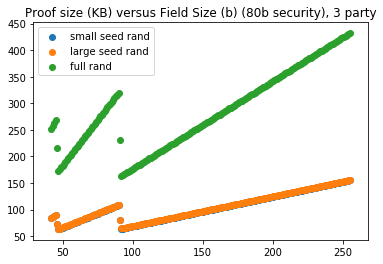

In [432]:
# PLOT PROOF SIZE VERSUS FIELD SIZE
B = 8
KiB = 1024*B
P=3
PR=2
x = np.array([fs])
yseedsmall = np.array([get_proof_size(HASH_BITS, COMM_RAND, True, sss[0], 
                                      f, sigma, P, PR, NUM_ASWI) / KiB for f in fs])
yseedbig = np.array([get_proof_size(HASH_BITS, COMM_RAND, True, sss[1], 
                                      f, sigma, P, PR, NUM_ASWI) / KiB for f in fs])
ynoseed = np.array([get_proof_size(HASH_BITS, COMM_RAND, False, 0, 
                                      f, sigma, P, PR, NUM_ASWI) / KiB for f in fs])

print("Best 80b seed proof size (KB): ",min([(get_proof_size(HASH_BITS, COMM_RAND, True, sss[0], 
                                      f, sigma, P, PR, NUM_ASWI) / KiB, f) for f in fs]))
print("Best 128b seed proof size (KB): ",min([(get_proof_size(HASH_BITS, COMM_RAND, True, sss[1], 
                                      f, sigma, P, PR, NUM_ASWI) / KiB, f) for f in fs]))
print("Best non-seed (full) proof size (KB): ", min([(get_proof_size(HASH_BITS, COMM_RAND, False, 0, 
                                      f, sigma, P, PR, NUM_ASWI) / KiB, f) for f in fs]))
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(x, yseedsmall, label="small seed rand")
ax.scatter(x, yseedbig, label="large seed rand")
ax.scatter(x, ynoseed, label="full rand")
plt.title("Proof size (KB) versus Field Size (b) (80b security), 3 party")
ax.legend()
plt.show()

Best 80b seed proof size (KB):  (73.7833251953125, 93)
Best 128b seed proof size (KB):  (74.2637939453125, 93)
Best non-seed (full) proof size (KB):  (145.5933837890625, 93)


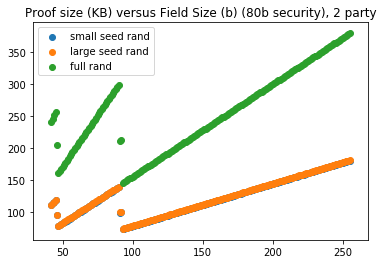

In [433]:
# PLOT PROOF SIZE VERSUS FIELD SIZE
B = 8
KiB = 1024*B
P=2
PR=1
x = np.array([fs])
yseedsmall = np.array([get_proof_size(HASH_BITS, COMM_RAND, True, sss[0], 
                                      f, sigma, P, PR, NUM_ASWI) / KiB for f in fs])
yseedbig = np.array([get_proof_size(HASH_BITS, COMM_RAND, True, sss[1], 
                                      f, sigma, P, PR, NUM_ASWI) / KiB for f in fs])
ynoseed = np.array([get_proof_size(HASH_BITS, COMM_RAND, False, 0, 
                                      f, sigma, P, PR, NUM_ASWI) / KiB for f in fs])

print("Best 80b seed proof size (KB): ",min([(get_proof_size(HASH_BITS, COMM_RAND, True, sss[0], 
                                      f, sigma, P, PR, NUM_ASWI) / KiB, f) for f in fs]))
print("Best 128b seed proof size (KB): ",min([(get_proof_size(HASH_BITS, COMM_RAND, True, sss[1], 
                                      f, sigma, P, PR, NUM_ASWI) / KiB, f) for f in fs]))
print("Best non-seed (full) proof size (KB): ", min([(get_proof_size(HASH_BITS, COMM_RAND, False, 0, 
                                      f, sigma, P, PR, NUM_ASWI) / KiB, f) for f in fs]))
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(x, yseedsmall, label="small seed rand")
ax.scatter(x, yseedbig, label="large seed rand")
ax.scatter(x, ynoseed, label="full rand")
plt.title("Proof size (KB) versus Field Size (b) (80b security), 2 party")
ax.legend()
plt.show()

Unsurprisingly, better soundness means bigger proof size.

Best proof size ((KB), F, sigma):  (21.5482177734375, 51, 40)
Best proof size ((KB), F, sigma):  (40.9462890625, 72, 60)
Best proof size ((KB), F, sigma):  (63.1268310546875, 47, 80)
Best proof size ((KB), F, sigma):  (141.6112060546875, 71, 128)


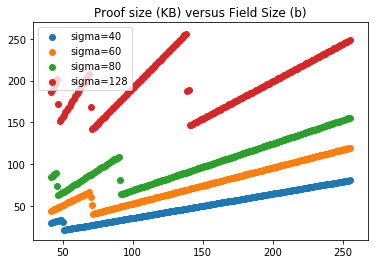

In [435]:
# PLOT PROOF SIZE VERSUS FIELD SIZE FOR DIFFERENT SIGMAS
B = 8
KiB = 1024*B
P=3
PR=2
x = np.array(fs)
ys = []
for s in sigmas:
    ys.append(np.array([get_proof_size(HASH_BITS, COMM_RAND, True, SEED_SIZE, 
                                          f, s, P, PR, NUM_ASWI) / KiB for f in fs]))
    print("Best proof size ((KB), F, sigma): ",min([(get_proof_size(HASH_BITS, COMM_RAND, True, SEED_SIZE, 
                                          f, s, P, PR, NUM_ASWI) / KiB, f, s-2) for f in fs]))
    
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for i in range(len(sigmas)):
    ax.scatter(x, ys[i], label="sigma={}".format(sigmas[i]-2))
plt.title("Proof size (KB) versus Field Size (b)")
ax.legend()
plt.show()  

Best proof size ((KB), F, sigma):  (30.543212890625, 82, 40)
Best proof size ((KB), F, sigma):  (45.244384765625, 82, 60)
Best proof size ((KB), F, sigma):  (64.40185546875, 92, 80)
Best proof size ((KB), F, sigma):  (146.4830322265625, 141, 128)


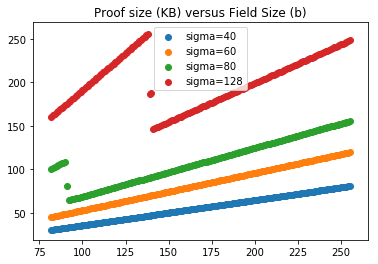

In [436]:
# Zoomed in version
B = 8
KiB = 1024*B
fs = fs[40:]
x = np.array(fs)
ys=[]
for s in sigmas:
    ys.append(np.array([get_proof_size(HASH_BITS, COMM_RAND, True, SEED_SIZE, 
                                          f, s, P, PR, NUM_ASWI) / KiB for f in fs]))
    print("Best proof size ((KB), F, sigma): ",min([(get_proof_size(HASH_BITS, COMM_RAND, True, SEED_SIZE, 
                                          f, s, P, PR, NUM_ASWI) / KiB, f, s-2) for f in fs]))
    
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for i in range(len(sigmas)):
    ax.scatter(x, ys[i], label="sigma={}".format(sigmas[i]-2))
plt.title("Proof size (KB) versus Field Size (b)")
ax.legend()
plt.show()  

The best number of parties (if the verifier reveals P-1 views) is 3; it barely beats 2.

In retrospect, this makes sense; you need 52 reps for 3 parties to get to sigma=82 (80 soundness in the overall protocol), and 82 reps for 2 parties.  And 3x52 is slightly less than 2x82.

Best proof size ((KB), parties, reveal p-1):  (64.40185546875, 3)
p= 2 , total proof size:  101.22998046875
    p= 2 , IKOS reps: 82
    p= 2 , round 1: 5248.0
    p= 2 , round 3: 5248.0
    p= 2 , round 5: 93163.5
p= 3 , total proof size:  64.40185546875
    p= 3 , IKOS reps: 52
    p= 3 , round 1: 4992.0
    p= 3 , round 3: 4992.0
    p= 3 , round 5: 55963.5
p= 4 , total proof size:  67.51708984375
    p= 4 , IKOS reps: 41
    p= 4 , round 1: 5248.0
    p= 4 , round 3: 5248.0
    p= 4 , round 5: 58641.5
p= 4 ,reveal 2, total proof size:  219.02490234375


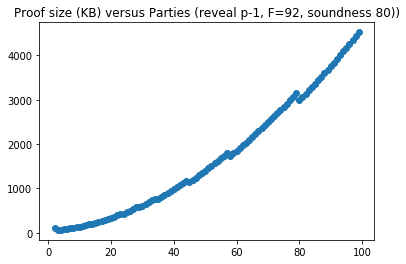

In [444]:
# PROOF SIZE VERSUS PARTIES
B = 8
KiB = 1024*B
F = 92
sigma = 80+2
x = np.array(ps)
y = np.array([get_proof_size(HASH_BITS, COMM_RAND, True, SEED_SIZE, 
                                          F, sigma, p, p-1, NUM_ASWI) / KiB for p in ps])
print("Best proof size ((KB), parties, reveal p-1): ",min([(get_proof_size(HASH_BITS, COMM_RAND, True, SEED_SIZE, 
                                          F, sigma, p, p-1, NUM_ASWI) / KiB, p) for p in ps]))


for p in [2,3,4]:
    print("p=",p,", total proof size: ", get_proof_size(HASH_BITS, COMM_RAND, True, SEED_SIZE, 
                                          F, sigma, p, p-1, NUM_ASWI) / KiB) 
    print("    p=",p,", IKOS reps:",get_num_ikos_reps(sigma,p,1))
    print("    p=",p,", round 1:",get_round1(HASH_BITS, sigma, p, p-1)/B)
    print("    p=",p,", round 3:",get_round3(HASH_BITS, sigma, p, p-1)/B)
    print("    p=",p,", round 5:",get_round5(COMM_RAND, RAND_FROM_SEED, SEED_SIZE, F, sigma, p,p-1, NUM_ASWI)/B)
print("p=",p,",reveal 2, total proof size: ", get_proof_size(HASH_BITS, COMM_RAND, True, SEED_SIZE, 
                                          F, sigma, p, 2, NUM_ASWI) / KiB)    

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(x, y)
plt.title("Proof size (KB) versus Parties (reveal p-1, F=92, soundness 80))")
#ax.legend()
plt.show()

Finally, proof size versus number of switches.  There seem to be a few cutoff points, again likely related to bucketing.  For our case, F=94 leads to 9 being a good number of switches.

f= 92 | switches= 1 | pf size (KB)= 36.37060546875
f= 92 | switches= 2 | pf size (KB)= 43.37841796875
f= 92 | switches= 3 | pf size (KB)= 50.38623046875
f= 92 | switches= 4 | pf size (KB)= 57.39404296875
f= 92 | switches= 5 | pf size (KB)= 64.40185546875
f= 93 | switches= 1 | pf size (KB)= 36.6246337890625
f= 93 | switches= 2 | pf size (KB)= 43.7086181640625
f= 93 | switches= 3 | pf size (KB)= 50.7926025390625
f= 93 | switches= 4 | pf size (KB)= 57.8765869140625
f= 93 | switches= 5 | pf size (KB)= 64.9605712890625
f= 94 | switches= 1 | pf size (KB)= 36.878662109375
f= 94 | switches= 2 | pf size (KB)= 44.038818359375
f= 94 | switches= 3 | pf size (KB)= 51.198974609375
f= 94 | switches= 4 | pf size (KB)= 58.359130859375
f= 94 | switches= 5 | pf size (KB)= 65.519287109375
f= 95 | switches= 1 | pf size (KB)= 37.1326904296875
f= 95 | switches= 2 | pf size (KB)= 44.3690185546875
f= 95 | switches= 3 | pf size (KB)= 51.6053466796875
f= 95 | switches= 4 | pf size (KB)= 58.8416748046875
f= 95 | 

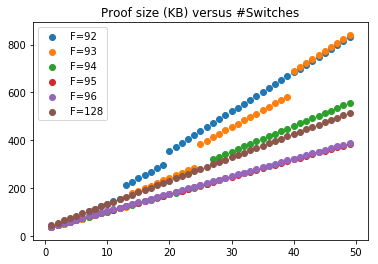

In [456]:
# PLOT PROOF SIZE VERSUS SWITCHES
B = 8
KiB = 1024*B
sigma = 80+2
P = 3
PR = 2
x = np.array(naswis)
bestF = 0
bestFSize = 10000000000
fs = [92, 93, 94, 95, 96, 128]
BEST_F = 94
ys = []
for f in fs:
    ys.append(np.array([get_proof_size(HASH_BITS, COMM_RAND, True, SEED_SIZE, 
                                          f, sigma, P, PR, n) / KiB for n in naswis]))
    for i in range(5):
        print("f=",f,"| switches=",x[i], "| pf size (KB)=",ys[-1][i])


    
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for i in range(len(fs)):
    ax.scatter(x, ys[i], label="F={}".format(fs[i]))
plt.title("Proof size (KB) versus #Switches")
ax.legend()
plt.show()